# 环境准备。
安装好 mindspore，参考 [mindspore安装](https://www.mindspore.cn/install)，本demo使用环境如下:

```
MacOS 12.5.1 aarch64
python 3.9.15
mindspore 1.9.0
```

In [1]:
import mindspore as ms
import numpy as np
from matplotlib import pyplot as plt
from mindspore import nn, Tensor, Parameter, ops
from mindspore.nn import Adam

from qutrunk.circuit import QCircuit
from qutrunk.circuit.gates import PauliZ, Rx, Ry, H, Rz

ms.set_seed(12)  # 设置生成随机数的种子
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

# 构建编码线路 encoder，将经典数据编码到量子数据

In [2]:
def circuit_encoder(encoder_data):
    alpha0, alpha1, alpha2 = [float(f) for f in encoder_data]
    circuit = QCircuit()
    qreg = circuit.allocate(1)
    H * qreg[0]
    Rx(alpha0) * qreg[0]
    Ry(alpha1) * qreg[0]
    Rz(alpha2) * qreg[0]
    return circuit

# 定义用于训练的含参量子线路 ansatz

In [3]:
def circuit_ansatz():
    circuit = QCircuit()
    q = circuit.allocate(1)
    angles = ["theta-0", "theta-1"]
    params = circuit.create_parameters(angles)

    Rx(params[0]) * q[0]
    Ry(params[1]) * q[0]

    return circuit

# 用于测量/投影的哈密顿量

In [4]:
def hamiltonian():
    circuit = QCircuit()
    qreg = circuit.allocate(1)
    return PauliZ(qreg[0])

# 连接编码线路和用于训练的线路，绑定当前参数值

In [5]:
def join_circuit(encoder, ansatz, inputs):
    params = {"theta-" + str(i): inputs[i] for i in range(len(inputs))}
    ansatz.bind_parameters(params)
    encoder.append_circuit(ansatz)
    return encoder

# 用参数位移算法计算量子线路梯度值

In [6]:
def parameter_shift(inputs, exp_op, params, shift=np.pi / 2):
    """
    Backward pass computation, calculate the gradient of quantum circuit by parameter shift rule.
    """
    params = np.array(params)

    gradients = []
    for i in range(len(params)):
        shift_right = np.copy(params)
        shift_right[i] += shift
        shift_left = np.copy(params)
        shift_left[i] -= shift

        circuit = join_circuit(circuit_encoder(inputs), circuit_ansatz(), shift_right)
        expectation_right = -1 * circuit.expval_pauli(exp_op)

        circuit = join_circuit(circuit_encoder(inputs), circuit_ansatz(), shift_left)
        expectation_left = -1 * circuit.expval_pauli(exp_op)

        gradient = np.array([expectation_right]) - np.array([expectation_left])
        gradients.append(gradient)
    gradients = np.squeeze(np.array(gradients).T)
    return gradients

# 自定义训练网络

In [7]:
class CustomTrainOneStepCell(nn.Cell):

    def __init__(self, optimizer, exp_op):
        super(CustomTrainOneStepCell, self).__init__(auto_prefix=False)
        self.optimizer = optimizer  # 定义优化器
        self.exp_op = exp_op

        self.weights = self.optimizer.parameters  # 待更新参数
        self.grad = parameter_shift

    def construct(self, *inputs):
        inputs = inputs[0]
        # 前向计算输出
        circuit = join_circuit(circuit_encoder(inputs), circuit_ansatz(), self.weights[0])
        loss = -1 * circuit.expval_pauli(self.exp_op)

        # 用参数位移计算梯度
        grads = self.grad(inputs, self.exp_op, self.weights[0])  # 进行反向传播，计算梯度
        loss = ops.depend(loss, self.optimizer((Tensor(grads),)))  # 使用优化器更新梯度
        return loss


# 训练

In [8]:
ITR = 200
LR = 0.02
enc_d = np.array([0.2, 0.3, 0.4])
op = hamiltonian()
opt = Adam([Parameter(Tensor(np.random.rand(2)), name="ansatz-theta")], learning_rate=LR)

train_net = CustomTrainOneStepCell(opt, op)

loss_list = []
for i in range(ITR):
    res = train_net(Tensor(enc_d))
    loss_list.append(res)
    if i % 10 == 0:
        print(i, ": ", res)

0 :  0.7668047514370688
10 :  0.5776929907628878
20 :  0.3325678696719703
30 :  0.04738609826396856
40 :  -0.24636333350397138
50 :  -0.5099832106240192
60 :  -0.7137835980462199
70 :  -0.8489997499702759
80 :  -0.9263823281867517
90 :  -0.9651338819493985
100 :  -0.9826035771563745
110 :  -0.9901325604038415
120 :  -0.9936146493238158
130 :  -0.9955699006879649
140 :  -0.9968941273798805
150 :  -0.9978613836927627
160 :  -0.9985640171107846
170 :  -0.9990584242598857
180 :  -0.9993953109734033
190 :  -0.9996189661066741


# 结果呈现

In [9]:
ans_d = train_net.weights[0]
print("final theta: ", ans_d.value())

circ = join_circuit(circuit_encoder(enc_d), circuit_ansatz(), ans_d)
state = circ.get_statevector()
print("state: ", str(state))
fid = np.abs(np.vdot(state, [1, 0])) ** 2
print("fidelity", ": ", fid)

final theta:  [ 2.19642544 -1.07710791]
state:  [0.38983534-0.92082061j 0.0097964 +0.00467482j]
fidelity :  0.999882176674514


# 损失曲线

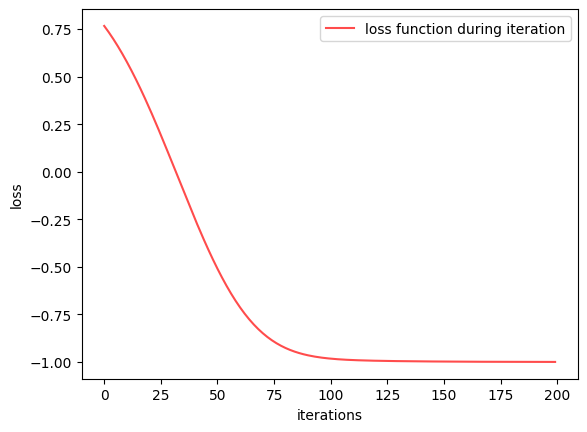

In [10]:
plt.figure(1)
ITR_list = []
for i in range(ITR):
    ITR_list.append(i)
func = plt.plot(ITR_list, loss_list, alpha=0.7, marker='', linestyle='-', color='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(labels=["loss function during iteration"], loc='best')
plt.show()